# Final Exercise - Putting it All Together

In this last section, you'll write a full ETL pipeline for the GDP data. That means you'll extract the World Bank data, transform the data, and load the data all in one go. In other words, you'll want one Python script that can do the entire process.

Why would you want to do this? Imagine working for a company that creates new data every day. As new data comes in, you'll want to write software that periodically and automatically extracts, transforms, and loads the data.

To give you a sense for what this is like, you'll extract the GDP data one line at a time. You'll then transform that line of data and load the results into a SQLite database. The code in this exercise is somewhat tricky.

Here is an explanation of how this Jupyter notebook is organized:
1. The first cell connects to a SQLite database called worldbank3.db and creates a table to hold the gdp data. You do 

2. The second cell has a function called extract_line(). This function is a [Python generator](https://wiki.python.org/moin/Generators). Essentially, a generator is like a regular function except instead of a return statement, a generator has a yield statement. Generators allow you to use functions in a for loop. In essence, this function will allow you to read in a data file one line at a time, run a transformation on that row of data, and then move on to the next row in the file.

3. The third cell contains a function called transform_indicator_data(). This function receives a line from the csv file and transforms the data in preparation for a load step.

4. The fourth cell contains a function called load_indicator_data(), which loads the trasnformed data into the gdp table in the worldbank3.db database.

5. The fifth cell runs the ETL pipeilne

6. The sixth cell runs a query against the database to make sure everything worked correctly.

You'll need to modify the third and fourth cells.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

In [2]:
# run this cell to create a database and a table, called gdp, to hold the gdp data

# connect to the database
# the database file will be worldbank.db
# note that sqlite3 will create this database file if it does not exist already
conn = sqlite3.connect('../data/wordbank3.db')

# get a cursor
cur = conn.cursor()

# drop the test table in case it already exists
cur.execute("DROP TABLE IF EXISTS gdp")

# create the test table including project_id as a primary key
cur.execute("CREATE TABLE gdp (countryname TEXT, countrycode TEXT, year INTEGER, gdp REAL, PRIMARY KEY (countrycode, year));")

conn.commit()
conn.close()


In [3]:
# Generator for reading in one line at a time
# generators are useful for data sets that are too large to fit in RAM
def extract_lines(file):
    while True:
        line = file.readline()
        if not line:
            break
        yield line

In [4]:

# This function has two inputs:
#   data, which is a row of data from the gdp csv file
#   colnames, which is a list of column names from the csv file
# The output should be a list of [countryname, countrycode, year, gdp] values
# In other words, the output would look like:
# [[Aruba, ABW, 1994, 1.330168e+09], [Aruba, ABW, 1995, 1.320670e+09], ...]
#



# transform the indicator data    
def transform_indicator_data(data, colnames):
    
    # get rid of quote marks
    for i, datum in enumerate(data):
        data[i] = datum.replace('"','')
    
    # the data variable contains a list of data in the form [countryname, countrycode, 1960, 1961, 1962,...]
    # since this is the format of the data in the csv file. Extract the countryname from the list 
    # and put the result in the country variable
    country = data[0]
    
    # these are "countryname" values that are not actually countries
    non_countries = ['World',
     'High income',
     'OECD members',
     'Post-demographic dividend',
     'IDA & IBRD total',
     'Low & middle income',
     'Middle income',
     'IBRD only',
     'East Asia & Pacific',
     'Europe & Central Asia',
     'North America',
     'Upper middle income',
     'Late-demographic dividend',
     'European Union',
     'East Asia & Pacific (excluding high income)',
     'East Asia & Pacific (IDA & IBRD countries)',
     'Euro area',
     'Early-demographic dividend',
     'Lower middle income',
     'Latin America & Caribbean',
     'Latin America & the Caribbean (IDA & IBRD countries)',
     'Latin America & Caribbean (excluding high income)',
     'Europe & Central Asia (IDA & IBRD countries)',
     'Middle East & North Africa',
     'Europe & Central Asia (excluding high income)',
     'South Asia (IDA & IBRD)',
     'South Asia',
     'Arab World',
     'IDA total',
     'Sub-Saharan Africa',
     'Sub-Saharan Africa (IDA & IBRD countries)',
     'Sub-Saharan Africa (excluding high income)',
     'Middle East & North Africa (excluding high income)',
     'Middle East & North Africa (IDA & IBRD countries)',
     'Central Europe and the Baltics',
     'Pre-demographic dividend',
     'IDA only',
     'Least developed countries: UN classification',
     'IDA blend',
     'Fragile and conflict affected situations',
     'Heavily indebted poor countries (HIPC)',
     'Low income',
     'Small states',
     'Other small states',
     'Not classified',
     'Caribbean small states',
     'Pacific island small states']
    
    # filter out country name values that are in the above list
    if country not in non_countries:
        
        # In this section, you'll convert the single row of data into a data frame
        # The advantage of converting a single row of data into a data frame is that you can
        # re-use code from earlier in the lesson to clean the data
        
        # convert the data variable into a numpy array
        # Use the ndmin=2 option
        data_array = np.array(data, ndmin=2)
        
        #  reshape the data_array so that it is one row and 63 columns
        data_array.reshape(1, 63)
        
        # convert the data_array variable into a pandas dataframe
        # Note that you can specify the column names as well using the colnames variable
        # Also, replace all empty strings in the dataframe with nan (HINT: Use the replace module and np.nan)
        df = pd.DataFrame(data = data_array, columns=colnames).replace('', np.nan)
        
        #  Drop the 'Indicator Name' and 'Indicator Code' columns
        df.drop(['\n','Indicator Name','Indicator Code' ], axis=1, inplace=True)
        
        # Reshape the data sets so that they are in long format
        # The id_vars should be Country Name and Country Code
        # You can name the variable column year and the value column gdp
        # HINT: Use the pandas melt() method
        # HINT: This was already done in a previous exercise
        df_melt = df.melt(id_vars= ['Country Name', 'Country Code'], var_name='year', value_name='gdp')
        
        # Iterate through the rows in df_melt
        # For each row, extract the country, countrycode, year, and gdp values into a list like this:
        #     [country, countrycode, year, gdp]
        # If the gdp value is not null, append the row (in the form of a list) to the results variable
        # Finally, return the results list after iterating through the df_melt data
        # HINT: the iterrows() method would be useful
        # HINT: to check if gdp is equal to nan, you might want to convert gdp to a string and compare to the
        #       string 'nan
        results = []
        for index, values in df_melt.iterrows():
            country, countrycode, year, gdp = values
            if str(gdp) != 'nan':
                results.append([country, countrycode, year, gdp])
        return results
    


In [5]:

# This function loads data into the gdp table of the worldbank3.db database
# The input is a list of data outputted from the transformation step that looks like this:
# [[Aruba, ABW, 1994, 1.330168e+09], [Aruba, ABW, 1995, 1.320670e+09], ...]

# The function does not return anything. Instead, the function iterates through the input and inserts each
# value into the gdp data set.

def load_indicator_data(results):
    
    # connect to the worldbank3.db database using the sqlite3 library
    conn = sqlite3.connect('../data/wordbank3.db')
    
    #  create a cursor object
    cur = conn.cursor()
    
    if results:
        
        # iterate through the results variable and insert each result into the gdp table
        for result in results:
            
            # extract the countryname, countrycode, year, and gdp from each iteration
            countryname, countrycode, year, gdp = result

            #  prepare a query to insert a countryname, countrycode, year, gdp value
            sql_string = 'INSERT INTO gdp (countryname, countrycode, year, gdp) VALUES ("{}", "{}", {}, {});'.format(countryname, countrycode, year, gdp)


            # connect to database and execute query
            try:
                cur.execute(sql_string)
            # print out any errors (like if the primary key constraint is violated)
            except Exception as e:
                print('error occurred:', e, result)

    # commit changes and close the connection
    conn.commit()
    conn.close()
    
    return None

In [6]:
# Execute this code cell to run the ETL pipeline
# You do not need to change anything in this cell

# open the data file            
with open('../data/gdp_data.csv') as f:
    # execute the generator to read in the file line by line
    for line in extract_lines(f):
        # split the comma separated values
        data = line.split(',')
        # check the length of the line because the first four lines of the csv file are not data
        if len(data) == 63:
            # check if the line represents column names
            if data[0] == '"Country Name"':
                colnames = []
                # get rid of quote marks in the results to make the data easier to work with
                for i, datum in enumerate(data):
                    colnames.append(datum.replace('"',''))
            else:
                # transform and load the line of indicator data
                results = transform_indicator_data(data, colnames)
                load_indicator_data(results)

In [7]:
# Execute this code cell to output the values in the gdp table
# You do not need to change anything in this cell

# connect to the database
# the database file will be worldbank.db
# note that sqlite3 will create this database file if it does not exist already
conn = sqlite3.connect('../data/wordbank3.db')

# get a cursor
cur = conn.cursor()

# create the test table including project_id as a primary key
df = pd.read_sql("SELECT * FROM gdp", con=conn)

conn.commit()
conn.close()

df

,countryname,countrycode,year,gdp
0,Aruba,ABW,1994,1.330168e+09
1,Aruba,ABW,1995,1.320670e+09
2,Aruba,ABW,1996,1.379888e+09
3,Aruba,ABW,1997,1.531844e+09
4,Aruba,ABW,1998,1.665363e+09
5,Aruba,ABW,1999,1.722799e+09
6,Aruba,ABW,2000,1.873453e+09
7,Aruba,ABW,2001,1.920263e+09
8,Aruba,ABW,2002,1.941095e+09
9,Aruba,ABW,2003,2.021302e+09


# Conclusion

ETL Pipelines involve extracting data from one source, which in this case was a csv file, then transforming the data into a more usable form, and finally loading the data somewhere else.

The purpose of ETL pipelines is to make data more usable and accessible. 

<Container object of 3 artists>

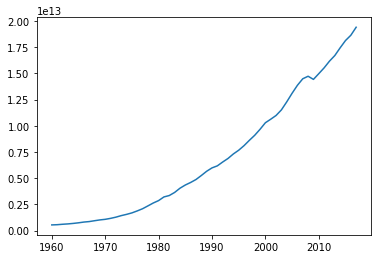

In [8]:
y= df.loc[df.countrycode.str.contains('USA')].gdp.values
x= df.loc[df.countrycode.str.contains('USA')].year.values
plt.errorbar(x,y)